Using cache found in C:\Users\ronen/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\ronen\cars-distance-managment\.venv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in C:\Users\ronen/.cache\torch\hub\intel-isl_MiDaS_master


[INFO] Total frames: 1501, picking frame #1288
[INFO] Processing frame 1288

0: 384x640 4 cars, 1 truck, 600.9ms
Speed: 23.6ms preprocess, 600.9ms inference, 28.5ms postprocess per image at shape (1, 3, 384, 640)


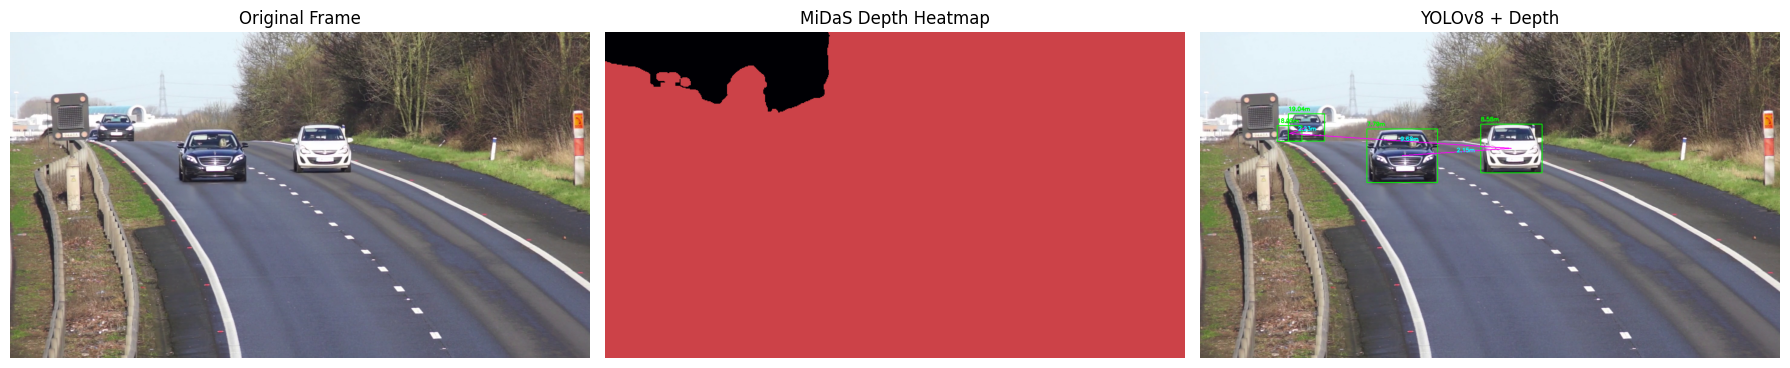

In [14]:
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Load MiDaS model and transform
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load YOLOv8
yolo = YOLO("yolov8s.pt")

def midas_depth(frame, scratcher = 3_000):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_np = np.array(img_rgb)

    result = transform(img_np)
    input_tensor = result["image"].to(device) if isinstance(result, dict) else result.to(device)

    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        prediction = midas(input_tensor)
        if prediction.dim() == 3:
            prediction = prediction.unsqueeze(1)
        elif prediction.dim() == 2:
            prediction = prediction.unsqueeze(0).unsqueeze(0)

        prediction_resized = torch.nn.functional.interpolate(
            prediction,
            size=img_np.shape[:2],
            mode="bicubic",
            align_corners=False
        )

    depth_map = prediction_resized.squeeze().cpu().numpy()

    # 🔄 Invert the MiDaS depth values properly: closer = larger number
    inverted_depth = scratcher * (1 / (depth_map + 1e-6))  # prevent divide by zero
    return inverted_depth




def depth_to_heatmap(depth_map):
    d_min, d_max = np.min(depth_map), np.max(depth_map)
    norm_depth = (depth_map - d_min) / (d_max - d_min + 1e-8)
    heatmap = (255 * (1 - norm_depth)).astype(np.uint8)
    return cv2.applyColorMap(heatmap, cv2.COLORMAP_INFERNO)

def annotate_with_yolo(frame, yolo_results, depth_map, gamma=2):
    annotated = frame.copy()
    car_info = []  # List to store (cx, cy, distance)

    for result in yolo_results:
        for box in result.boxes:
            cls = int(box.cls[0])
            if cls != 2:  # Only 'car' class
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            cx = np.clip(cx, 0, depth_map.shape[1] - 1)
            cy = np.clip(cy, 0, depth_map.shape[0] - 1)
            distance = depth_map[cy, cx]

            distance *= gamma
            distance *= sigmoid(distance)

            car_info.append((cx, cy, distance))

            label = f"{distance:.2f}m"
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return annotated, car_info


from itertools import combinations

from itertools import combinations

def annotate_pairwise_depth_distances(image, car_info):
    annotated = image.copy()

    # Sort cars by distance from the camera (nearest first)
    sorted_info = sorted(car_info, key=lambda x: x[2])  # (cx, cy, distance)

    for i in range(len(sorted_info) - 1):
        x1, y1, d1 = sorted_info[i]
        x2, y2, d2 = sorted_info[i + 1]

        # Draw line from car i to car i+1 (in front of it)
        distance_diff = np.sqrt((d1 - d2)**2 + 4)  # positive means the next car is farther

        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2

        # Draw line and label
        cv2.line(annotated, (x1, y1), (x2, y2), (255, 0, 255), 2)
        cv2.putText(annotated, f"{distance_diff:.2f}m", (mid_x, mid_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    return annotated


def plot_results(frame, depth_heatmap, yolo_annotated):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(depth_heatmap, cv2.COLOR_BGR2RGB))
    axs[1].set_title("MiDaS Depth Heatmap")
    axs[1].axis("off")

    axs[2].imshow(cv2.cvtColor(yolo_annotated, cv2.COLOR_BGR2RGB))
    axs[2].set_title("YOLOv8 + Depth")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

def main(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    selected_frame_idx = random.randint(0, frame_count - 1)
    print(f"[INFO] Total frames: {frame_count}, picking frame #{selected_frame_idx}")

    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame == selected_frame_idx:
            print(f"[INFO] Processing frame {current_frame}")
            depth_map = midas_depth(frame)
            depth_heatmap = depth_to_heatmap(depth_map)
            yolo_results = yolo(frame)
            annotated_yolo, car_info = annotate_with_yolo(frame, yolo_results, depth_map)
            annotated_with_3d = annotate_pairwise_depth_distances(annotated_yolo, car_info)
            plot_results(frame, depth_heatmap, annotated_with_3d)

            break
        current_frame += 1

    cap.release()

# Run
video_path = "854671-hd_1920_1080_25fps.mp4"
main(video_path)


In [2]:
%pip install roboflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
from roboflow import Roboflow

# Initialize Roboflow with your API key
rf = Roboflow(api_key="mq4xwNHHmCOLigA78VzE")

# Load your project by name and version
project = rf.workspace("jk-nanu0").project("final2-xiiin")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


In [25]:
import cv2
import matplotlib.pyplot as plt

def show_prediction_on_frame(frame_path, prediction):
    # Load image with OpenCV
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Draw boxes
    for obj in prediction['predictions']:
        # Example keys, adjust to your actual prediction keys
        x1, y1 = int(obj['x'] - obj['width'] / 2), int(obj['y'] - obj['height'] / 2)
        x2, y2 = int(obj['x'] + obj['width'] / 2), int(obj['y'] + obj['height'] / 2)
        label = obj['class']
        conf = obj['confidence']

        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        # Put label text
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [26]:
import cv2
import random

def random_frame_predictions(video_path, model, confidence=40, overlap=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        raise ValueError("Video has zero frames.")

    random_frame_index = random.randint(0, frame_count - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)

    ret, frame = cap.read()
    if not ret:
        raise ValueError(f"Failed to read frame at index {random_frame_index}")

    # Optionally save the frame to disk
    frame_path = "temp_frame.jpg"
    cv2.imwrite(frame_path, frame)

    # Run inference on the saved frame image path
    prediction = model.predict(frame_path, confidence=40).json()
    show_prediction_on_frame(frame_path, prediction)


    cap.release()
    return prediction

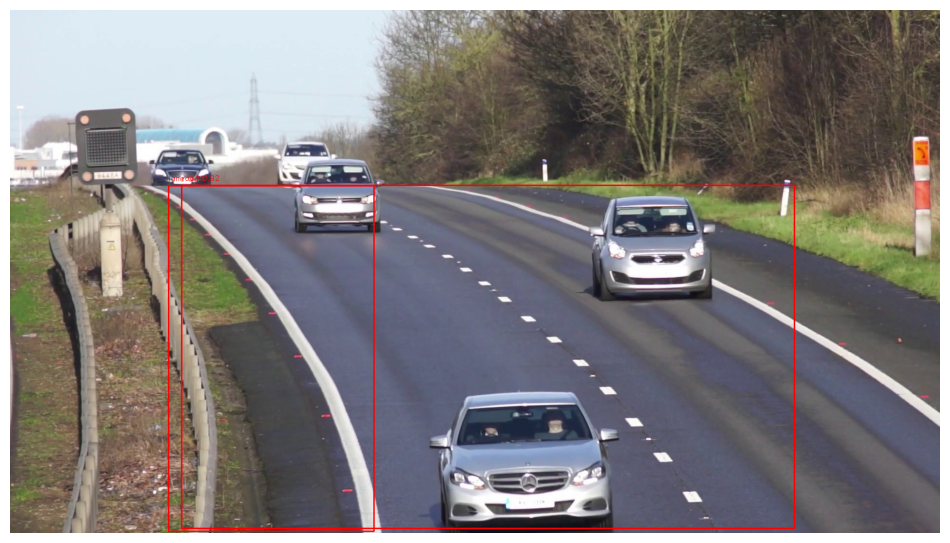

{'predictions': [{'x': 986.5,
   'y': 716.5,
   'width': 1265.0,
   'height': 707.0,
   'confidence': 0.9193678498268127,
   'class': 'road',
   'points': [{'x': 354.0, 'y': 364.5},
    {'x': 354.0, 'y': 389.8125},
    {'x': 360.0, 'y': 393.1875},
    {'x': 360.0, 'y': 394.875},
    {'x': 363.0, 'y': 396.5625},
    {'x': 366.0, 'y': 396.5625},
    {'x': 369.0, 'y': 398.25},
    {'x': 369.0, 'y': 399.9375},
    {'x': 372.0, 'y': 401.625},
    {'x': 372.0, 'y': 403.3125},
    {'x': 375.0, 'y': 405.0},
    {'x': 375.0, 'y': 406.6875},
    {'x': 381.0, 'y': 410.0625},
    {'x': 381.0, 'y': 411.75},
    {'x': 384.0, 'y': 413.4375},
    {'x': 384.0, 'y': 415.125},
    {'x': 387.0, 'y': 416.8125},
    {'x': 390.0, 'y': 416.8125},
    {'x': 396.0, 'y': 420.1875},
    {'x': 396.0, 'y': 421.875},
    {'x': 399.0, 'y': 423.5625},
    {'x': 399.0, 'y': 425.25},
    {'x': 405.0, 'y': 428.625},
    {'x': 405.0, 'y': 430.3125},
    {'x': 408.0, 'y': 432.0},
    {'x': 408.0, 'y': 435.375},
    {'x': 4

In [27]:
random_frame_predictions(video_path = r"C:\Users\ronen\Downloads\854671-hd_1920_1080_25fps.mp4", model = model)